From google drive DNA_Sensor/Reports/on elecron spin relaxation:

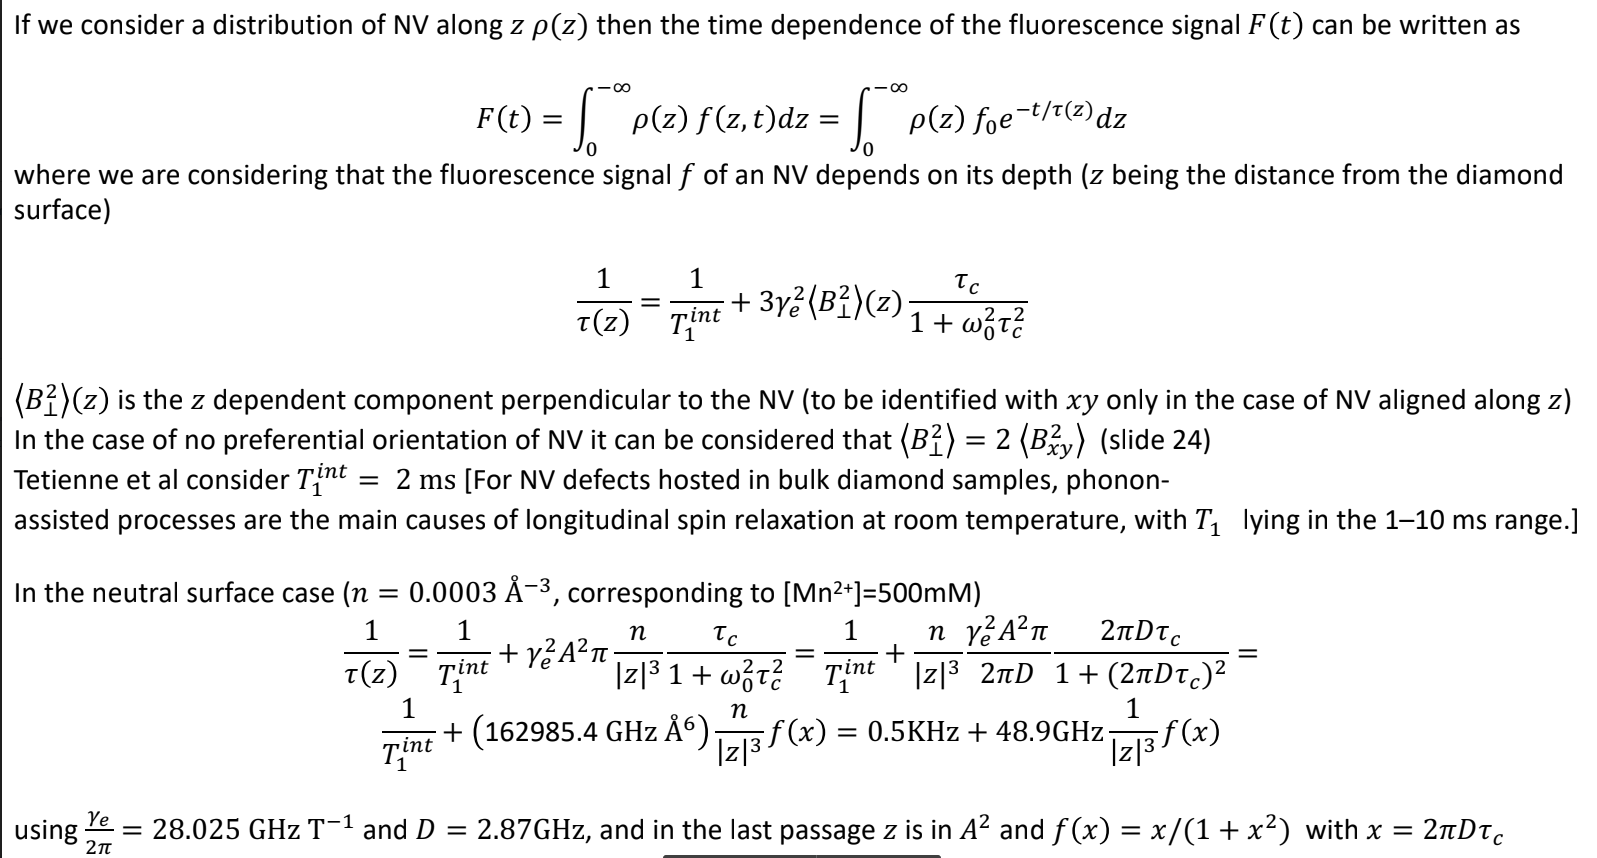

Let's begin by defining $\rho(z)$.

From Justas's mail: 
"The average depth of NVs can be estimated by simulating N ions penetration depth with SRIM-2013, which is a simple tool to use. 
I did a quick simulation (see attached files) for you and for 4keV you get a mean range of 6.6nm and sigma=2.7nm."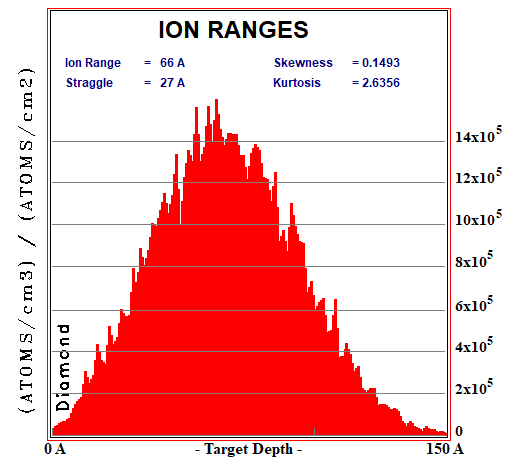

In [1]:
import numpy as np

In [2]:
# Define rho

def gaussian(x, mu = 6.6, sig = 2.7):   # Default values are in nm.
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

Text(0, 0.5, 'rho(z)')

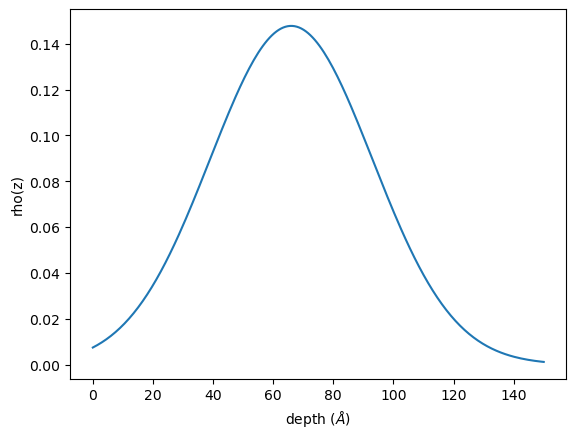

In [3]:
# Plot rho
import matplotlib.pyplot as plt
x_values = np.linspace(0, 15, 200)
plt.plot(x_values*10, gaussian(x_values))
plt.xlabel("depth ($\AA$)")
plt.ylabel("rho(z)")

Now let's define $1/\tau(z)$...
$$
\frac{1}{\tau(z)}=\frac{1}{T_1^{i n t}}+\gamma_e^2 A^2 \pi \frac{n}{|z|^3} \frac{\tau_c}{1+\left(2 \pi D \tau_c\right)^2}
$$
Tetienne et al consider $T_1^{int}= 2$ ms [For NV defects hosted in bulk diamond samples, phonon-
assisted processes are the main causes of longitudinal spin relaxation at room temperature, with T_1 lying in the 1–10 ms range.]


=> $1/T_1^{int} = 1/(2ms) = 0.5*10^3 Hz$

In [4]:
# Define one over tau
A = -5.492940828862188
gamma_e = 176.0810   # GHz T^-1
D = 2.87         #GHz
def one_over_tau(z, *,tau_c, n, one_over_T_1_int = .5e-3):
    return one_over_T_1_int +  (n/z**3) * ((gamma_e**2)*(A**2)*np.pi*tau_c)/(1+(2*np.pi*D*tau_c)**2)

NEUTRAL CASE:
$n = 3 \cdot 10^{-4} Å^{-3} = 3 \cdot 10^{-7} nm^3$

In [5]:
# NEUTRAL CASE
n = 3e-7 # nm^3

In [6]:
# Check the values with the one in the report
n*((gamma_e**2)*(A**2)*np.pi)/(2*np.pi*D)        # GHz nm^-3

0.04889271968236864

Text(0.5, 0, '$z$')

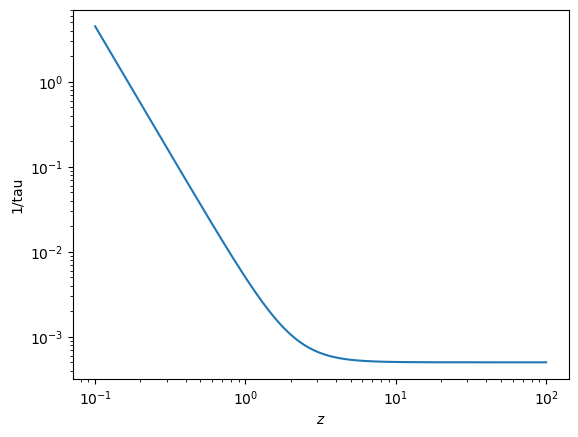

In [7]:
# Plot 1/tau(z)
z_values = np.logspace(-1, 2, 500)

plt.plot(z_values, one_over_tau(z_values, tau_c = .6, n = n))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('$z$')

Text(0.5, 0, '$z$')

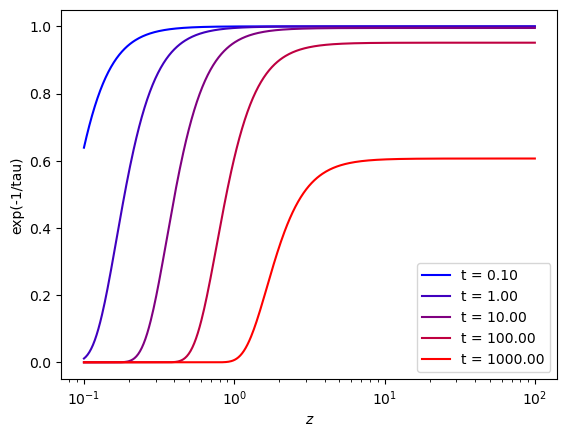

In [38]:
# Plot exp(-1/tau(z))
z_values = np.logspace(-1, 2, 500)
t_values = np.logspace(-1, 3, 5)
colors=np.linspace(0,1,len(t_values))
for t, color_ in zip(t_values, colors):    
    plt.plot(z_values, np.exp(-t*one_over_tau(z_values, tau_c = .6, n = n, )), color = (color_, 0, 1-color_), label = f't = {t:.2f}')
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('exp(-t/tau)')
plt.xlabel('$z$')

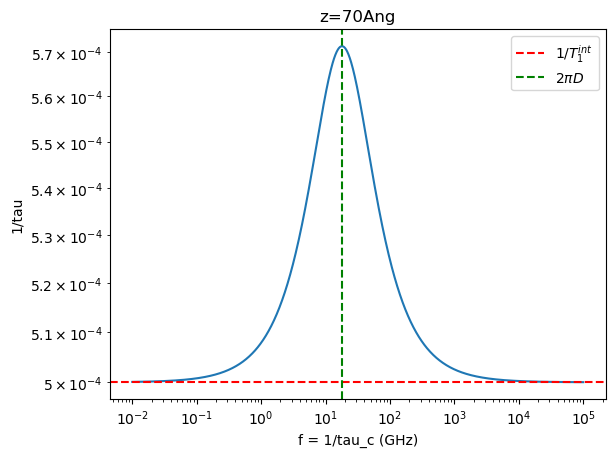

In [9]:
# Plot 1/tau as a function of f = 1/tau_c
f_values = np.logspace(-2, 5, 1000)
plt.plot(f_values, one_over_tau(z = 7, tau_c = 1/f_values, n = n))
plt.title('z=70Ang')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('f = 1/tau_c (GHz)')
plt.axhline(y = .5e-3, color = 'r', linestyle = '--', label='$1/T_1^{int}$')
plt.axvline(x = 2*np.pi*D, color = 'g', linestyle = '--', label='$2\pi D$')
plt.legend()

$$
F(t)=\int_0^{-\infty} \rho(z) f(z, t) d z=\int_0^{-\infty} \rho(z) f_0 e^{-t / \tau(z)} d z
$$
Now that we have $\rho(z)$ and $1/\tau(z)$ let's define the integrand and integrate!

In [10]:
def integrand(z, t=1, *, mu = 6.6, sig = 2.7, tau_c, n = 3e-7, one_over_T_1_int = .5e-3, charged = False, sigma = 5.27e-5):
    rho_ = gaussian(z, mu=mu, sig=sig)
    if not charged:
        one_over_tau_ = one_over_tau(z = z, tau_c = tau_c, n = n)
    if charged:
        one_over_tau_ = one_over_tau_charged(z = z, tau_c = tau_c, sigma = sigma)
    return rho_* f_0 * np.exp(-t * one_over_tau_)

In [24]:
# ASSUMED VALUES for a few of the next plots, for the last plot only f_0 is set to 1,
# so that follwing plots can be interpreted as F(t)/f_0
f_0 = 1
tau_c = 1/(2*np.pi*D)
t = 1


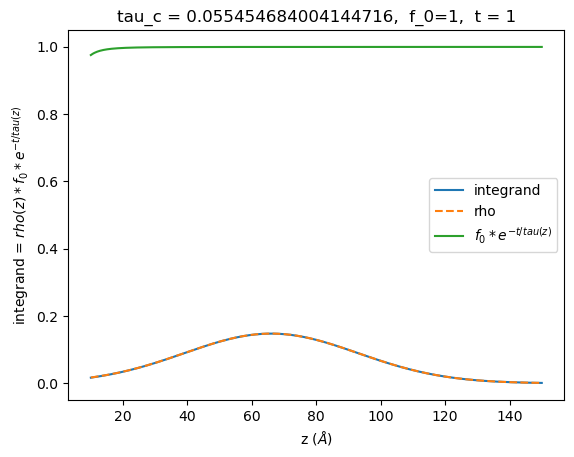

In [25]:
# Plot integrand (z) for above parameters
z_values = np.linspace(1, 15, 500)
plt.title(f'tau_c = {tau_c},  f_0={f_0},  t = {t}')
plt.plot(z_values*10, integrand(z_values, tau_c=tau_c, n=n), label='integrand')
plt.plot(z_values*10, gaussian(z_values), label='rho', linestyle='--')
one_over_tau_array = one_over_tau(z_values, tau_c = tau_c, n = n)
plt.plot(z_values*10, f_0 * np.exp(-t * one_over_tau_array), label= '$f_0* e^{-t / tau(z)}$')
plt.ylabel('integrand = $rho(z)* f_0* e^{-t / tau(z)}$')
plt.xlabel('z ($\AA$)')
plt.legend()

Time to integrate! $$
F(t)=\int_0^{-\infty} \rho(z) f_0 e^{-t / \tau(z)} d z
$$

In [13]:
# Simpson integration
from scipy.integrate import simpson

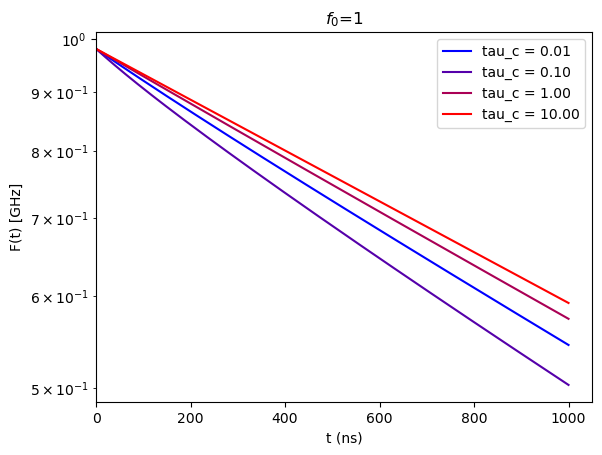

In [14]:
# Plot F(t) for different values of tau_c
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-2,1,4)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, n=n), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()
#plt.ylim(0, None)

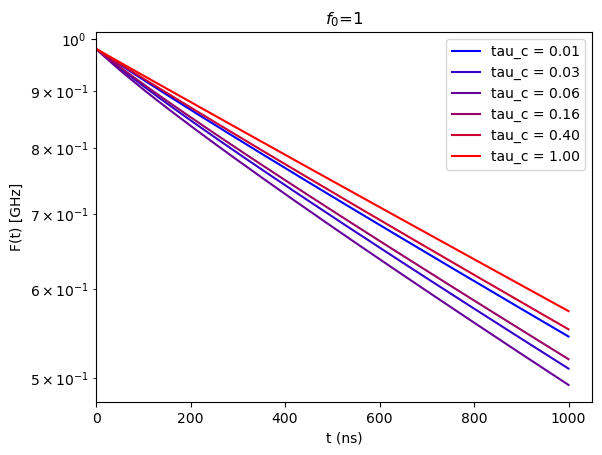

In [15]:
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-2,0,6)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, n=n), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))
    

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()

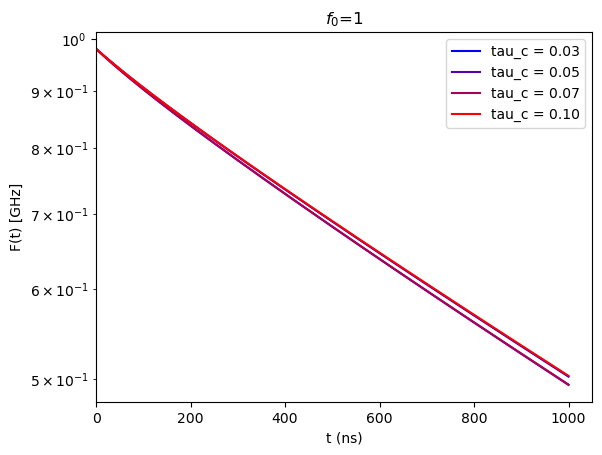

In [16]:
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-1.5,-1,4)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, n=n), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))
    

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()

Minimum (for these parameters) is at $\tau_c\simeq 0.05-0.07$

Now for the charged surface case!
$$
\langle B^2 \rangle = A^2 \frac{\pi}{3}\sigma \frac{3}{2z^4}
$$
$$
\frac{1}{\tau(z)}=\frac{1}{T_1^{\text {int }}}+3 \gamma_e^2\left\langle B_{\perp}^2\right\rangle(z) \frac{\tau_c}{1+\omega_0^2 \tau_c^2} =\frac{1}{T_1^{\text {int }}}+3 \gamma_e^2A^2 \frac{\pi}{2z^4}\sigma \frac{\tau_c}{1+\omega_0^2 \tau_c^2} =\frac{1}{T_1^{\text {int }}}+\frac{1}{2z^4} \frac{3 \gamma_e^2A^2\pi \sigma \tau_c}{1+(2\pi D \tau_c)^2}
$$


$\sigma = 0.00527 Ang^2 = 5.27 \cdot 10^{-5} nm^2$

In [17]:
def one_over_tau_charged(z, *,tau_c, sigma = 5.27e-5, one_over_T_1_int = .5e-3):
    return one_over_T_1_int +  (1/(2*z**4)) * (3*(gamma_e**2)*(A**2)*np.pi*sigma*tau_c)/(1+(2*np.pi*D*tau_c)**2)

Text(0.5, 0, '$z$')

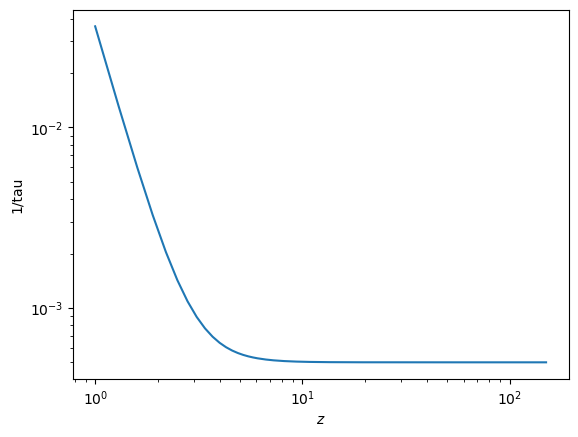

In [18]:
# Plot 1/tau(z)
z_values = np.linspace(1, 150, 500)
plt.plot(z_values, one_over_tau_charged(z_values, tau_c = 20))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('$z$')

Text(0.5, 0, '$z$')

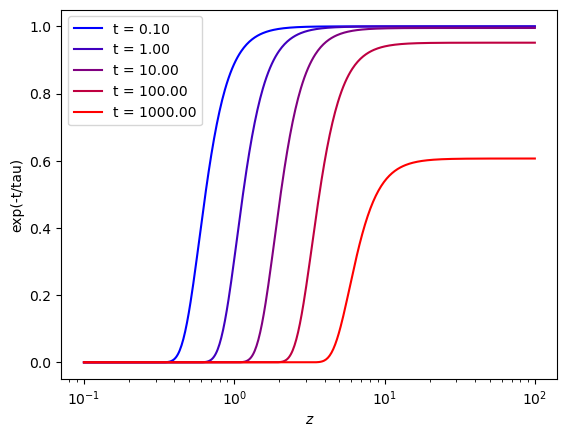

In [40]:
# Plot exp(-t/tau(z))
z_values = np.logspace(-1, 2, 500)
t_values = np.logspace(-1, 3, 5)
colors=np.linspace(0,1,len(t_values))
for t, color_ in zip(t_values, colors):    
    plt.plot(z_values, np.exp(-t*one_over_tau_charged(z_values, tau_c = .6)), color = (color_, 0, 1-color_), label = f't = {t:.2f}')
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('exp(-t/tau)')
plt.xlabel('$z$')

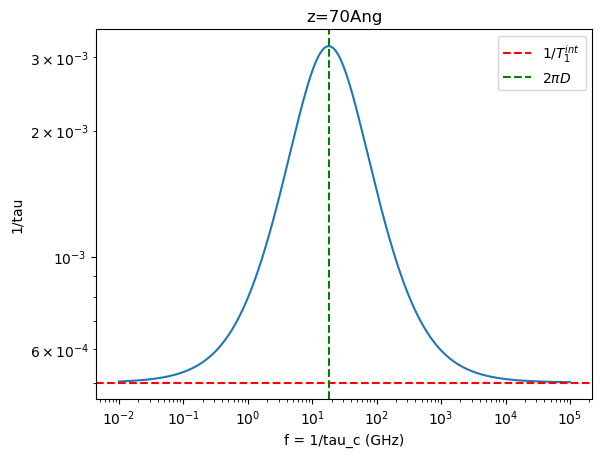

In [19]:
# Plot 1/tau as a function of f = 1/tau_c
f_values = np.logspace(-2, 5, 1000)
plt.plot(f_values, one_over_tau_charged(z = 7, tau_c = 1/f_values))
plt.title('z=70Ang')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('f = 1/tau_c (GHz)')
plt.axhline(y = .5e-3, color = 'r', linestyle = '--', label='$1/T_1^{int}$')
plt.axvline(x = 2*np.pi*D, color = 'g', linestyle = '--', label='$2\pi D$')
plt.legend()

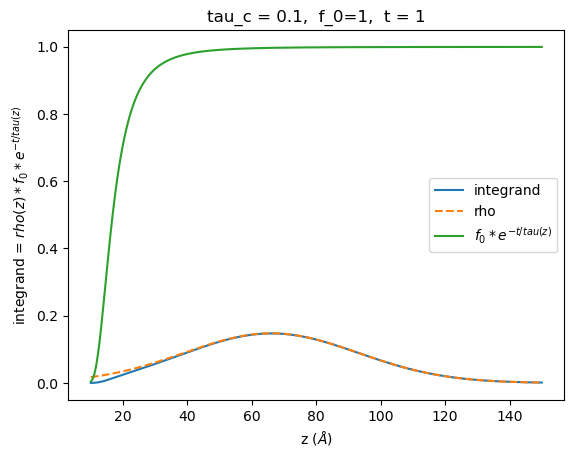

In [20]:
# Plot integrand (z) for above parameters
z_values = np.linspace(1, 15, 500)
plt.title(f'tau_c = {tau_c},  f_0={f_0},  t = {t}')
plt.plot(z_values*10, integrand(z_values, tau_c=tau_c, charged = True), label='integrand')
plt.plot(z_values*10, gaussian(z_values), label='rho', linestyle='--')
one_over_tau_array = one_over_tau_charged(z_values, tau_c = tau_c,)
plt.plot(z_values*10, f_0 * np.exp(-t * one_over_tau_array), label= '$f_0* e^{-t / tau(z)}$')
plt.ylabel('integrand = $rho(z)* f_0* e^{-t / tau(z)}$')
plt.xlabel('z ($\AA$)')
plt.legend()

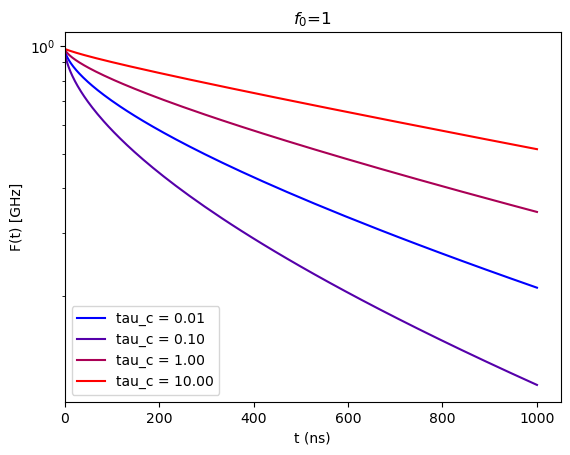

In [21]:
# Plot F(t) for different values of tau_c
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-2,1,4)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, charged = True), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()
#plt.ylim(0, None)

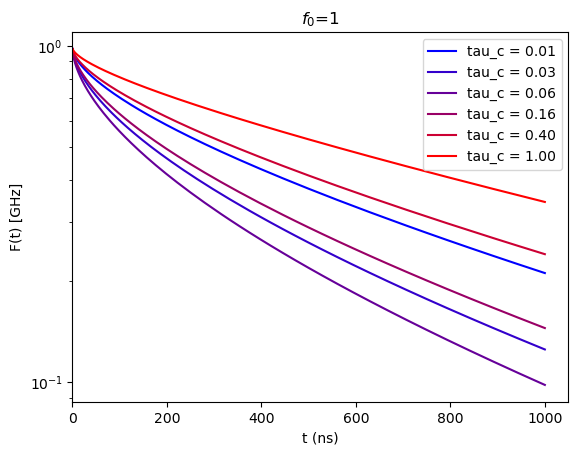

In [22]:
# Plot F(t) for different values of tau_c
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-2,0,6)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, charged = True), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()
#plt.ylim(0, None)


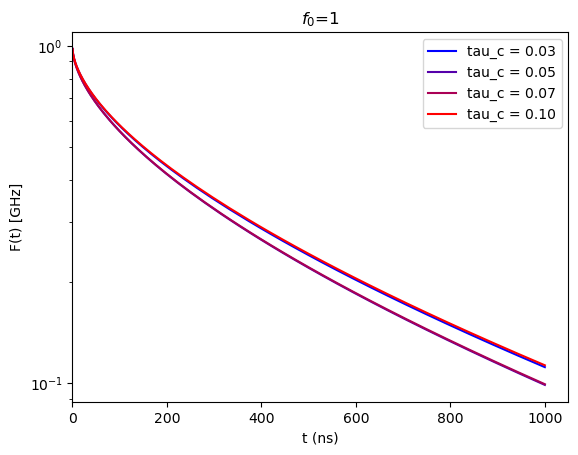

In [23]:
# Plot F(t) for different values of tau_c
t_values =np.logspace(-2,3,200)       # Plots 200 points spaced evenly on a log scale from t = 10^-2 to 10^3
tau_c_values = np.logspace(-1.5,-1,4)
colors=np.linspace(0,1,len(tau_c_values))
for tau_c, color_ in zip(tau_c_values, colors):
    integral = []
    for t_ in t_values:  
        integral.append(simpson(integrand(z_values, t = t_, tau_c=tau_c, charged = True), z_values))
    plt.plot(t_values, integral, label=f'tau_c = {tau_c:.2f}', color=(color_,0,1-color_))

plt.title(f'$f_0$={f_0}')
plt.xlabel('t (ns)')
plt.ylabel('F(t) [GHz]')
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, None)
plt.legend()
#plt.ylim(0, None)
